# Аналитическое решение

**Задание:**
    _В парикмахерской работают 3 мастера, а в зале ожидания расположены 3 стула. Поток клиентов имеет интенсивность 12 клиентов в час. Среднее время обслуживания составляет 20 мин. Определить показатели работы СМО._
    
Граф состояний нашей СМО выглядит следующим образом:
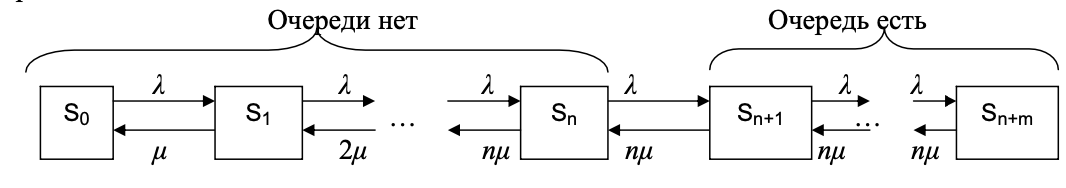

По сути добавляем очередь как каналы, так что пошаманив формулами для многоканальной СМО с отказами, получим наш результат. 

Наши параметры:
$$\lambda = 12, ~n = 3, ~m = 3, ~\overline{t}_{обс} = \frac{1}{\mu} = \frac{20}{60} \Rightarrow \mu = 3, ~\rho = \frac{\lambda}{\mu} = 4,$$

где $n$ - количество каналов, $m$ - длина очереди, $\lambda$ - интенсивность потока клиентов, $\mu$ - интенсивность потока обслуживания, $\rho$ - интенсивность нагрузки канала.

Тогда вероятность простоя:
$$P_0 = \left(1 + \sum\limits_{i=1}^{n}\frac{\rho^i}{i!} + \sum\limits_{k=n+1}^{n+m}\frac{p^k}{n^{k - n} \cdot n!}\right)^{-1} = \left(1 + \sum\limits_{i=1}^{n}\frac{\rho^i}{i!} + \frac{\rho^{n+1}}{n\cdot n!}\cdot\frac{1 -\left(\frac{\rho}{n}\right)^m}{1 - \frac{\rho}{n}}\right)^{-1} = \left(5 + 8 + \frac{64}{6} + \frac{4^4}{18}\cdot\frac{1 - \frac{64}{27}}{1 - \frac{4}{3}}\right)^{-1}\approx 0,01217$$

Тогда вероятность отказа:

$$P_{отк} = P_{n+m} = \frac{\rho^{n+m}}{n^m n!}P_0 \approx \frac{4^6}{3^3 \cdot 6} \cdot 0,01217\approx 0,3078$$

Вероятность образования очереди (по сути это нахождение в системе количества заявок не меньше, чем $n$, но не в точности $m$, то есть сумма вероятностей для состояний от $n$ до $n + m - 1$):
$$P_{оч} = \frac{\rho^n}{n!}\cdot \frac{1 -\left(\frac{\rho}{n}\right)^m}{1 - \frac{\rho}{n}} \cdot P_0 \approx \frac{64}{6}\cdot \frac{1 - \frac{64}{27}}{1 - \frac{4}{3}} \cdot 0,01217 \approx 0,5336$$

Относительная пропускная способность:
$$Q = 1 - P_{отк} \approx 1 - 0,3078 \approx 0,6922$$

Абсолютная пропускная способность:
$$ A = \lambda Q \approx 8,3064$$

Среднее число заявок в очереди:

$$L_{оч} = \frac{\rho^{n+1}}{n\cdot n!}\cdot\frac{1 -\left(\frac{\rho}{n}\right)^m\left(m + 1 - \frac{m}{n}\rho\right)}{\left(1 - \frac{\rho}{n}\right)^2} \cdot P_0 \approx 1,5578$$

Среднее число заявок на обслуживании:

$$L_{обс} = \frac{A}{\mu} \approx 2,7688$$

Среднее число заявок в системе:

$$L = L_{оч} + L_{обс} \approx 4,3266$$

Среднее время заявки в очереди:
$$T_{оч} = \frac{L_{оч}}{\lambda} \approx 0,12981 $$

Среднее время заявки в системе:
$$T = \frac{L}{\lambda} \approx 0,36055 $$


# Игра в имитацию, только вместо Тьюринга будет Эрланг

In [195]:
import simpy
import numpy as np
import logging
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

sns.set_style('darkgrid')

logging.basicConfig(format=' %(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG)
logger = logging.getLogger()
logger.setLevel(logging.INFO)


In [190]:
l = 12
mu = 3
num_barbers = 3
num_chairs = 3
EPSILON = 1e-4
num_exps = 1000

In [192]:
class Barbershop(object):
    def __init__(self, env,  log, num_barbers=num_barbers, num_chairs=num_chairs):
        self.env = env
        self.barbers = simpy.Resource(env, num_barbers)
        self.n = num_barbers
        self.m = num_chairs
        self.queue_size = 0
        self.log = log
        self.sums_log =  {
        "sum_queue_sizes": [0],
        "sum_declined" : [0],
        "sum_busy_barbers" : [0],
        "sum_all_times" : [0],
        "sum_wait_times" : [0],
    }

    def go_to_barber(self, client, verbose=logging.DEBUG):
        logger.setLevel(verbose)
        # Запишем размер очереди и время входа заявки
        self.log['queue_sizes'].append(self.queue_size)
        self.sums_log['sum_queue_sizes'].append(self.sums_log['sum_queue_sizes'][-1] + self.queue_size)
        
        self.log['busy_barbers'].append(self.barbers.count)
        self.sums_log['sum_busy_barbers'].append(self.sums_log['sum_busy_barbers'][-1] + self.barbers.count)
        
        self.log['arrival_times'].append(self.env.now)
        
        
        logger.debug(f"Client {client} entered barbershop at {self.env.now}")
        
        # Если очередь занята, то на выход         
        if self.queue_size + 1 > self.m:
            self.log['declined'].append(1)
            self.sums_log['sum_declined'].append(self.sums_log['sum_declined'][-1] + 1)
        
            self.log['wait_times'].append(0)
            self.sums_log['sum_wait_times'].append(self.sums_log['sum_wait_times'][-1] + 0)
            
            self.log['all_times_in_barbershop'].append(0)
            self.sums_log['sum_all_times'].append(self.sums_log['sum_all_times'][-1] + 0)
            logger.debug(f"Queue is full. Client {client} can't be serviced")
        else:
            # Считываем текущее состояние системы и делаем предпосчет для вычисления среднего, увеличиваем очередь
            state = np.zeros(self.n + self.m + 1)
            state[self.queue_size + self.barbers.count] = 1
            self.log['states'].append(state)
            self.log['sum_probs'].append(self.log['sum_probs'][-1] + self.log['states'][-1])
            self.queue_size += 1
            
            self.log['declined'].append(0)
            self.sums_log['sum_declined'].append(self.sums_log['sum_declined'][-1] + 0)
            # Запрашиваем парикмахера, ждем пока освободится
            barber = self.barbers.request()
            sat = self.env.now
            yield barber
            logger.debug(f"Client {client} is servicing at {self.env.now}")
            wt = self.env.now - sat
            
            self.log['wait_times'].append(wt)
            self.sums_log['sum_wait_times'].append(self.sums_log['sum_wait_times'][-1] + wt)
            
            self.queue_size -= 1
            
            # Начинаем стрижку
            started = yield self.env.timeout(np.random.exponential(1 / mu), value=self.env.now)
            self.barbers.release(barber)
            st = self.env.now - started
            self.log['serviced_times'].append(st)
            
            self.log['all_times_in_barbershop'].append(wt + st)
            self.sums_log['sum_all_times'].append(self.sums_log['sum_all_times'][-1] + wt + st)
            logger.debug(f"Client {client} gone at {self.env.now}")
            
    def plot_metrics(self, log_step=100):
        logger.setLevel(logging.INFO)
        while True:
            yield self.env.timeout(log_step)
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
            mean_times = np.array(self.sums_log['sum_all_times']) / list(range(1, len(self.sums_log['sum_all_times'])+1)) 
            queue_times = np.array(self.sums_log['sum_wait_times']) / list(range(1, len(self.sums_log['sum_wait_times'])+1))

            reject_probas = np.array(self.sums_log['sum_declined']) / list(range(1, len(self.sums_log['sum_declined'])+1)) 
            queue = np.array(self.sums_log['sum_queue_sizes']) / list(range(1, len(self.sums_log['sum_queue_sizes'] )+1)) 

            ax1.plot(mean_times, label="${T}_{СМО}$=%.3f" % mean_times[-1])
            ax1.plot(queue_times, label="${T}_{оч}$=%.3f" % queue_times[-1])

            ax1.plot(reject_probas, label="$P_{отк}$=%.3f" % reject_probas[-1])
            ax1.plot(queue, label="$L_{оч}$=%.3f" % queue[-1])
            ax1.legend()
            
#             mean_probs =[self.log['sum_probs'][i] / i for i in range(1, len(self.log['sum_probs']))]
            
            ax2.plot(self.log['diff_sqr'], label="diff=%.9f" % self.log['diff_sqr'][-1])
            clear_output(True)
            ax2.legend()
            plt.show()
            
            
    def check_convergence(self, main_process, eps, interval=50, type_of_convergence="quadratic"):
        while True:
            yield self.env.timeout(interval)
            condition = np.linalg.norm(self.log['sum_probs'][-1] / len(
                self.log['sum_probs']) - self.log['sum_probs'][-2] / (len(
                self.log['sum_probs']) - 1))
            self.log['diff_sqr'].append(condition)
            if condition < eps:
                main_process.interrupt(f"Convergence at {self.env.now}")
                return
            
            
    

    
def client_flow(env, l):
    logger.debug(f"Starting timeout {env.now}")
    return env.timeout(np.random.exponential(1 / l))

def run_process(env, barbershop, l=12):
    client = 0
    
    while True:
        yield client_flow(env, l)
        client += 1
        env.process(barbershop.go_to_barber(client, verbose=logging.INFO))
        barbershop.log['tot_clients'] = client
    

def run_exp(seed, eps, type_of_convergence="quadratic", max_iter=3000, plotting=False, n=3, m=3, l=12, mu=3):
    np.random.seed(seed)

    log = {
        "sum_probs" : [np.zeros(n + m + 1)],
        "states" : [np.zeros(n + m + 1)],
        "declined" : [0],
        "arrival_times" : [],
        "wait_times" : [],
        "serviced_times" : [],
        "all_times_in_barbershop" : [],
        "queue_sizes" : [],
        "busy_barbers" : [],
        "tot_clients" : 0,
        "diff_sqr": [],
    }
    
    
    env = simpy.Environment()
    barbershop = Barbershop(env, log)
    main = env.process(run_process(env, barbershop))
    plotting = env.process(barbershop.plot_metrics()) if plotting else None
    check = env.process(barbershop.check_convergence(main, eps))
    try:
        env.run(until=max_iter)
        print("Ooops")
    except simpy.Interrupt as i:
        logger.debug(f"Interrupted procces. Result: {i.cause}")
    return barbershop.log, barbershop.sums_log
    
    


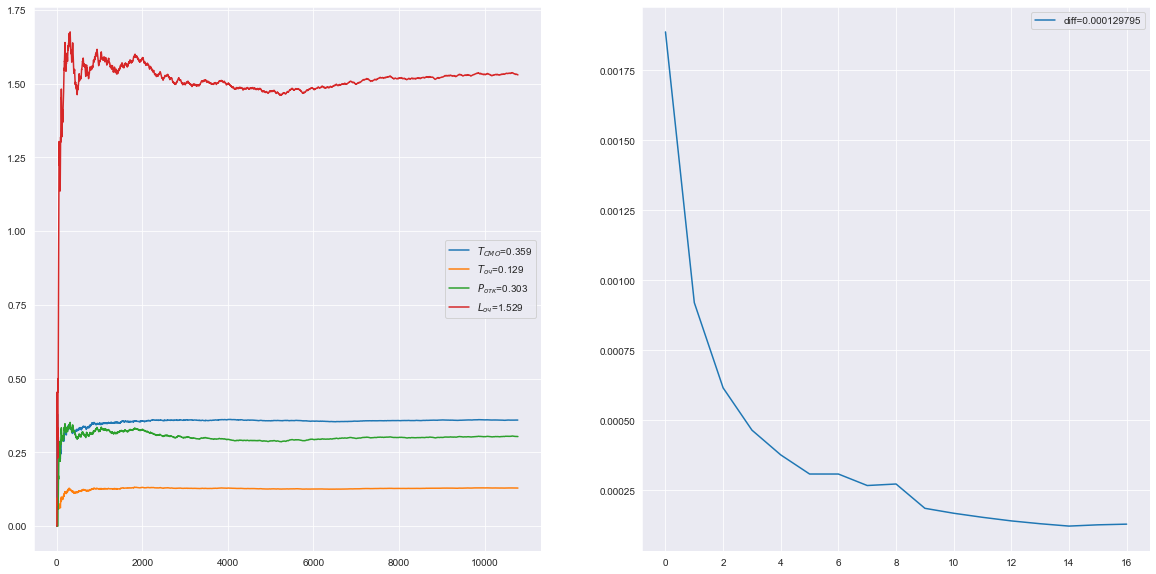

In [193]:
_, _ = run_exp(random_seeds[i], 1e-4, max_iter=10000, plotting=True)

In [196]:
logs = [{}] * num_exps
sums_logs = [{}] * num_exps
random_seeds = list(range(42, num_exps+42))
epss = [1e-4, 1e-5, 1e-6]

for i in tqdm(range(num_exps)):
    logs[i], sums_logs[i] = run_exp(random_seeds[i], epss[0], max_iter=10000, plotting=False)
    

  0%|          | 0/1000 [00:00<?, ?it/s]

# О сходимостях и прочем

Некоторые заметки, почему и что.

Многоканальные СМО с ограниченной очередью являются частным случаем процесса рождения-гибели, который является стационарным и эргодическим, то есть имеются предельные вероятности для состояний. В качестве метрики оценки сходимости выбрали норму разности, по сути хотим добиться сходимости в смысле среднеквадратического, которая является одной из сильнейших сходимостей с точки зрения транзитивности.

Для оценки модели воспользуемся волшебным аппаратом мат. статистики и проведем много-много экспериментов, дабы проверить какой распределение получим для выходных значений. Видим нормальное, значит оценки для статистик можно просто посчитать. Говорить, какой это довер интервал я не буду, не успела посчитать.


In [209]:
mean_vals = {
    'sum_all_times' : [],
    'sum_wait_times': [],
    'sum_declined': [],
    'sum_queue_sizes' :[],
    'sum_busy_barbers' : [],
    'sum_probs' :[]
}

for k, sums_log in enumerate(sums_logs):
    mean_times = np.array(sums_log['sum_all_times']) / list(range(1, len(sums_log['sum_all_times'])+1)) 
    mean_vals['sum_all_times'].append(mean_times[-1])
    
    queue_times = np.array(sums_log['sum_wait_times']) / list(range(1, len(sums_log['sum_wait_times'])+1))
    mean_vals['sum_wait_times'].append(queue_times[-1])
    
    reject_probas = np.array(sums_log['sum_declined']) / list(range(1, len(sums_log['sum_declined'])+1))
    mean_vals['sum_declined'].append(reject_probas[-1])
    
    queue = np.array(sums_log['sum_queue_sizes']) / list(range(1, len(sums_log['sum_queue_sizes'] )+1)) 
    mean_vals['sum_queue_sizes'].append(queue[-1])
    
    barbs = np.array(sums_log['sum_busy_barbers']) / list(range(1, len(sums_log['sum_busy_barbers'] )+1))
    mean_vals['sum_busy_barbers'].append(barbs[-1])
    
    empty = np.array(logs[k]['sum_probs'])[:, 0] / list(range(1, len(np.array(logs[k]['sum_probs'])[:, 0])+ 1))
    mean_vals['sum_probs'].append(empty[-1])
    

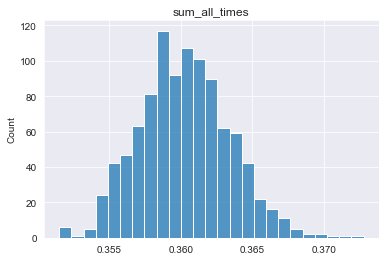

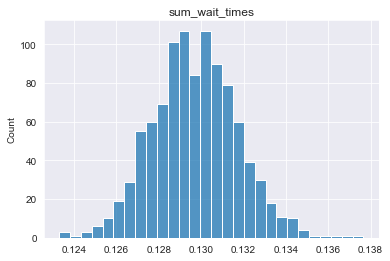

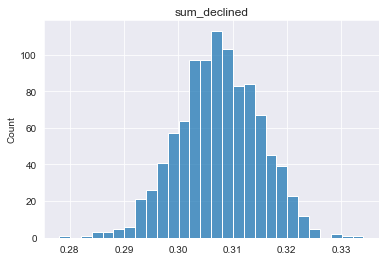

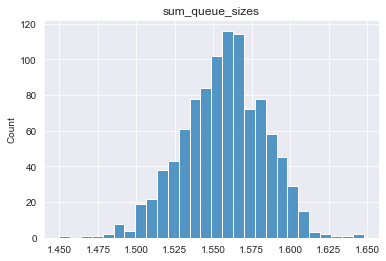

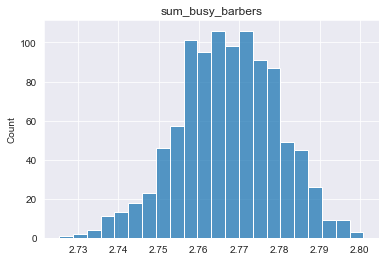

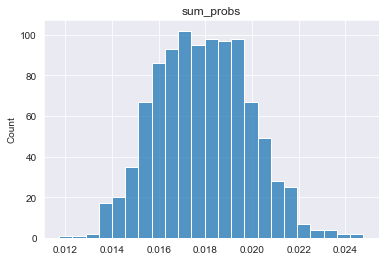

In [210]:
for key in mean_vals:
    sns.histplot(mean_vals[key], label=key)
    plt.title(key)
    plt.show()

In [211]:
got_values = {}
for key in mean_vals:
    arr = np.array(mean_vals[key])
    got_values[key]= (arr.mean(), arr.std())
    print(key,arr.mean(), arr.std())


sum_all_times 0.36024201456892885 0.0031363384737900404
sum_wait_times 0.1297043497295034 0.001996904963378352
sum_declined 0.30743841611876577 0.0075776205415912495
sum_queue_sizes 1.5567899009225994 0.02682141478296397
sum_busy_barbers 2.7672070116533267 0.01237148921308995
sum_probs 0.017895219874030685 0.001996045953405986


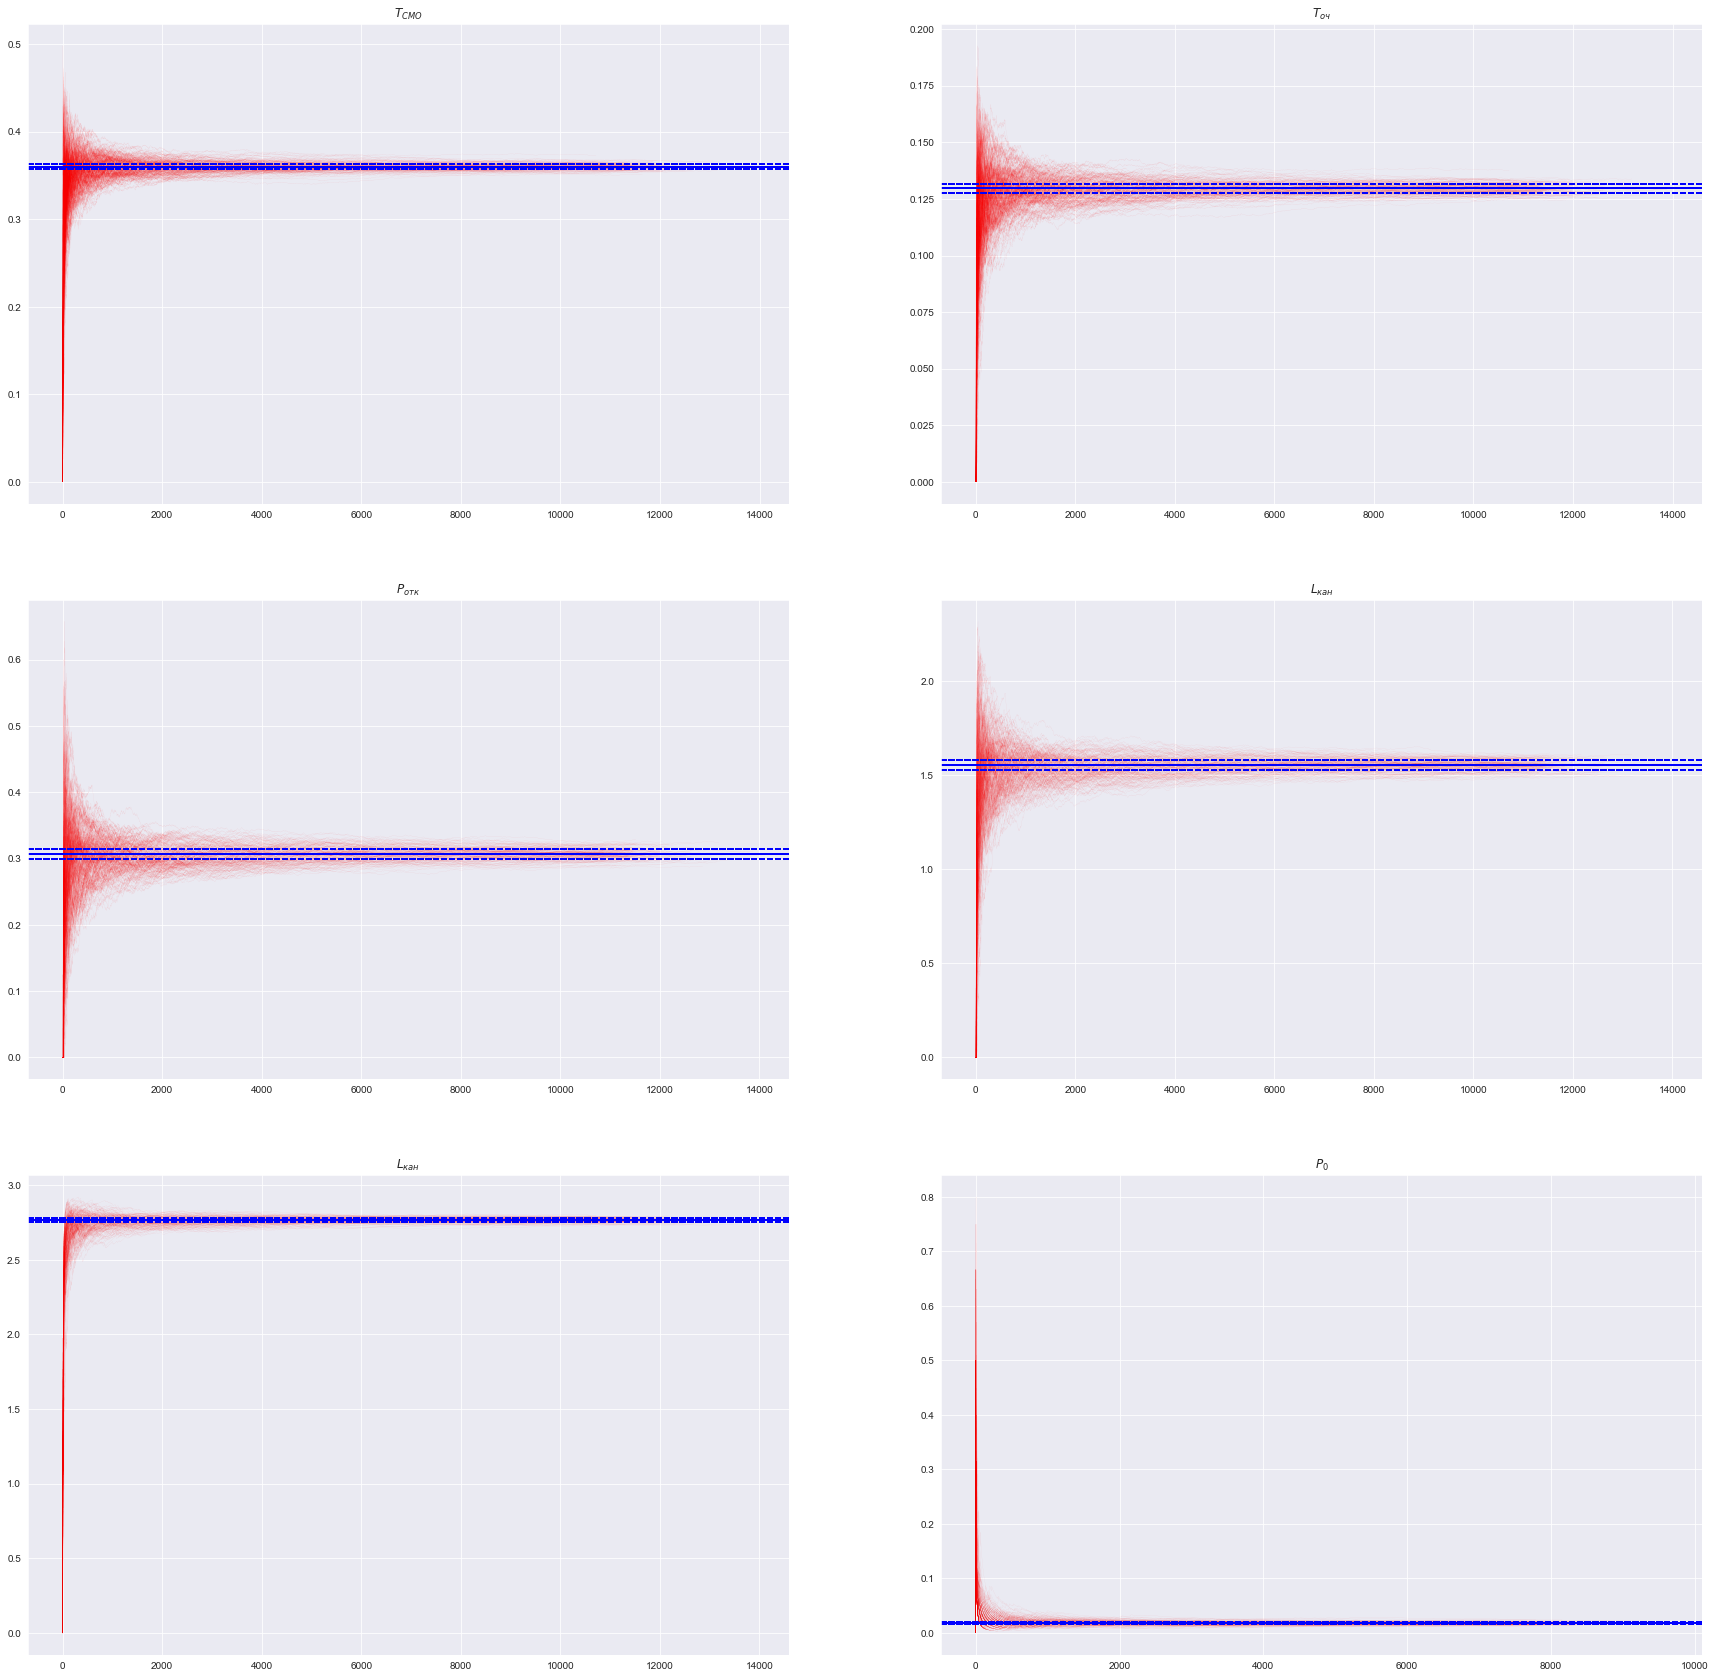

In [212]:
fig, axes = plt.subplots(3, 2, figsize=(30, 30))
for k, sums_log in enumerate(sums_logs[:200]):
    mean_times = np.array(sums_log['sum_all_times']) / list(range(1, len(sums_log['sum_all_times'])+1)) 
    mean_vals['sum_all_times'].append(mean_times[-1])
    
    queue_times = np.array(sums_log['sum_wait_times']) / list(range(1, len(sums_log['sum_wait_times'])+1))
    mean_vals['sum_wait_times'].append(queue_times[-1])
    
    reject_probas = np.array(sums_log['sum_declined']) / list(range(1, len(sums_log['sum_declined'])+1))
    mean_vals['sum_declined'].append(reject_probas[-1])
    
    queue = np.array(sums_log['sum_queue_sizes']) / list(range(1, len(sums_log['sum_queue_sizes'] )+1)) 
    mean_vals['sum_queue_sizes'].append(queue[-1])
    
    barbs = np.array(sums_log['sum_busy_barbers']) / list(range(1, len(sums_log['sum_busy_barbers'] )+1))
    mean_vals['sum_busy_barbers'].append(barbs[-1])
    
    empty = np.array(logs[k]['sum_probs'])[:, 0] / list(range(1, len(np.array(logs[k]['sum_probs'])[:, 0])+ 1))
    mean_vals['sum_probs'].append(empty[-1])
    

    axes[0, 0].plot(mean_times, color='red', alpha= 0.1, linewidth=0.2)
    axes[0, 0].axhline(y = got_values['sum_all_times'][0], color = 'b', linestyle = '-')
    axes[0, 0].axhline(y = got_values['sum_all_times'][0] + got_values['sum_all_times'][1], color = 'b', linestyle = '--')
    axes[0, 0].axhline(y = got_values['sum_all_times'][0] - got_values['sum_all_times'][1], color = 'b', linestyle = '--')
    axes[0, 0].set_title("${T}_{СМО}$")
#     axes[0, 0].legend()
    
    axes[0, 1].plot(queue_times, color='red', alpha=0.1, linewidth=0.2)
    axes[0, 1].axhline(y = got_values['sum_wait_times'][0], color = 'b', linestyle = '-')
    axes[0, 1].axhline(y = got_values['sum_wait_times'][0] + got_values['sum_wait_times'][1], color = 'b', linestyle = '--')
    axes[0, 1].axhline(y = got_values['sum_wait_times'][0] - got_values['sum_wait_times'][1], color = 'b', linestyle = '--')
    axes[0, 1].set_title("${T}_{оч}$")
#     axes[0, 1].legend()
    
    axes[1, 0].plot(reject_probas ,  color='red', alpha= 0.1, linewidth=0.2)
    axes[1, 0].axhline(y = got_values['sum_declined'][0], color = 'b', linestyle = '-')
    axes[1, 0].axhline(y = got_values['sum_declined'][0] + got_values['sum_declined'][1], color = 'b', linestyle = '--')
    axes[1, 0].axhline(y = got_values['sum_declined'][0] - got_values['sum_declined'][1], color = 'b', linestyle = '--')
    axes[1, 0].set_title("$P_{отк}$")
#     axes[1, 0].legend()
    
    axes[1, 1].plot(queue, label="$L_{оч}$",  color='red', alpha= 0.1, linewidth=0.2)
    axes[1, 1].axhline(y = got_values['sum_queue_sizes'][0], color = 'b', linestyle = '-')
    axes[1, 1].axhline(y = got_values['sum_queue_sizes'][0] + got_values['sum_queue_sizes'][1], color = 'b', linestyle = '--')
    axes[1, 1].axhline(y = got_values['sum_queue_sizes'][0] - got_values['sum_queue_sizes'][1], color = 'b', linestyle = '--')
    axes[1, 1].set_title("$L_{оч}$")
    
    axes[2, 0].plot(barbs, label="$L_{оч}$",  color='red', alpha= 0.1, linewidth=0.2)
    axes[2, 0].axhline(y = got_values['sum_busy_barbers'][0], color = 'b', linestyle = '-')
    axes[2, 0].axhline(y = got_values['sum_busy_barbers'][0] + got_values['sum_busy_barbers'][1], color = 'b', linestyle = '--')
    axes[2, 0].axhline(y = got_values['sum_busy_barbers'][0] - got_values['sum_busy_barbers'][1], color = 'b', linestyle = '--')
    axes[2, 0].set_title("$L_{кан}$")
    
    axes[2, 1].plot(empty, label="$P_0$",  color='red', alpha= 0.1, linewidth=0.2)
    axes[2, 1].axhline(y = got_values['sum_probs'][0], color = 'b', linestyle = '-')
    axes[2, 1].axhline(y = got_values['sum_probs'][0] + got_values['sum_probs'][1], color = 'b', linestyle = '--')
    axes[2, 1].axhline(y = got_values['sum_probs'][0] - got_values['sum_probs'][1], color = 'b', linestyle = '--')
    axes[2, 1].set_title("$P_0$")    
    
#     axes[1, 1].legend()
plt.show()

Полученные средние значения:
    $${T}_{оч} = 0,1297 \pm 0,0031$$
    $$P_{отк} = 0,3074 \pm 0,0075$$
    $$T_{смо} = 0,3602 \pm 0,0031$$
    $$L_{кан} = 2,7672 \pm 0,012$$
    $$L_{оч} = 1,5567 \pm 0,0268$$
    $$P_{0} = 0,0178 \pm 0,00199$$
    
Сошлось, но не очень точно, нужно уменьшить `tolerance` для итераций, тогда станет получше, но сейчас я делать это не буду :(
    
    